In [1]:
import os
import json
import requests
import pandas as pd
import geopandas as gpd
os.environ['USE_PYGEOS'] = '0'
import folium
import folium.plugins
import seaborn as sns
import glob
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import branca.colormap as cm
from folium import TileLayer 
from pystac_client import Client
from pystac import Item
from datetime import datetime
import stackstac
import xarray as xr
import rioxarray as rxr
from cartopy import crs as ccrs
import cartopy.feature as cf
import stackstac
import contextily as cx
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patches as patches

In [3]:
os.chdir('/home/jovyan/embell/portal2.0_maps/EPA/')

In [9]:
# Provide STAC and RASTER API endpoints
STAC_API_URL = "http://earth.gov/ghgcenter/api/stac"
RASTER_API_URL = "https://earth.gov/ghgcenter/api/raster"

# Please use the collection name similar to the one used in STAC collection
# Name of the collection for wetland methane monthly emissions 
collection_name = "epa-ch4emission-yeargrid-v2express"

In [8]:
# Fetching the collection from STAC collections using appropriate endpoint
# Using the Client module of pystac_client

catalog = Client.open(STAC_API_URL)

for collection in catalog.get_collections():
        print(collection.id)

ct-ch4-monthgrid-v2023
emit-ch4plume-v1
lpjwsl-wetlandch4-monthgrid-v1
goes-ch4plume-v1
odiac-ffco2-monthgrid-v2023
tm54dvar-ch4flux-monthgrid-v1
gra2pes-ghg-monthgrid-v1
sedac-popdensity-yeargrid5yr-v4.11
vulcan-ffco2-elc-res-yeargrid-v4
gosat-based-ch4budget-yeargrid-v1
tm54dvar-ch4flux-mask-monthgrid-v1
casagfed-carbonflux-monthgrid-v3
micasa-carbonflux-daygrid-v1
GEDI_ISS_L4B_Aboveground_Biomass_Density_Mean_201904-202303
lpjeosim-wetlandch4-daygrid-v1
lpjeosim-wetlandch4-monthgrid-v1
oco2geos-co2-daygrid-v10r
epa-ch4emission-yeargrid-v2express
lpjwsl-wetlandch4-daygrid-v1
oco2-mip-meanco2budget-yeargrid-v1
oco2-mip-co2budget-yeargrid-v1
eccodarwin-co2flux-monthgrid-v5
odiac-ffco2-monthgrid-v2022
vulcan-ffco2-yeargrid-v4
micasa-carbonflux-monthgrid-v1
cms-mangrove-agb-canopyheight-grid-v1.3
blueflux-ghgflux-daygrid-v1
VIIRS_SNPP_DayNightBand_At_Sensor_Radiance
odiac-ffco2-monthgrid-v2024
oco3-co2-sams-daygrid-v11r
geos-ghg-daygrid-vPRE


In [10]:
# Pick the collection
# Select GRA2PES collection: browse item_assets, spatial and temporal extent
collection = catalog.get_collection(collection_name)
collection

<CollectionClient id=epa-ch4emission-yeargrid-v2express>

In [14]:
items = list(collection.get_items())
items

[<Item id=epa-ch4emission-yeargrid-v2express-2020>,
 <Item id=epa-ch4emission-yeargrid-v2express-2019>,
 <Item id=epa-ch4emission-yeargrid-v2express-2018>,
 <Item id=epa-ch4emission-yeargrid-v2express-2017>,
 <Item id=epa-ch4emission-yeargrid-v2express-2016>,
 <Item id=epa-ch4emission-yeargrid-v2express-2015>,
 <Item id=epa-ch4emission-yeargrid-v2express-2014>,
 <Item id=epa-ch4emission-yeargrid-v2express-2013>,
 <Item id=epa-ch4emission-yeargrid-v2express-2012>]

In [27]:
ds = stackstac.stack(items,epsg=4326).squeeze()

In [28]:
ds

<xarray.DataArray 'stackstac-a87e15d90bfaa82dd68fc4bc13366855' (time: 9,
                                                                band: 34,
                                                                y: 351, x: 701)> Size: 602MB
dask.array<fetch_raster_window, shape=(9, 34, 351, 701), dtype=float64, chunksize=(1, 1, 351, 701), chunktype=numpy.ndarray>
Coordinates: (12/14)
  * time            (time) datetime64[ns] 72B 2012-01-01 ... 2020-01-01
    id              (time) <U39 1kB 'epa-ch4emission-yeargrid-v2express-2012'...
  * band            (band) <U27 4kB 'dwtd-waste' ... 'stationary-combustion-o...
  * x               (x) float64 6kB -130.1 -130.0 -129.9 ... -60.3 -60.2 -60.1
  * y               (y) float64 3kB 55.0 54.9 54.8 54.7 ... 20.3 20.2 20.1 20.0
    proj:code       <U11 44B 'EPSG:4326.0'
    ...              ...
    proj:shape      object 8B {700.0, 350.0}
    description     (band) <U227 31kB 'Annual methane emissions from Domestic...
    title           (band) <U60 8kB 'Waste - Domestic Wastewater Treatment & ...
    proj:transform  object 8B {0.09999999126821799, 0.0, -0.10000000437214586...
    proj:bbox       object 8B {-129.99999694387628, 19.99999923487448, -60.00...
    epsg            int64 8B 4326
Attributes:
    spec:           RasterSpec(epsg=4326, bounds=(-130.0999886399516, 19.9000...
    crs:            epsg:4326
    transform:      | 0.10, 0.00,-130.10|\n| 0.00,-0.10, 55.00|\n| 0.00, 0.00...
    resolution_xy:  (0.09999999126821799, 0.10000000437214585)

In [29]:
[print(b) for b in ds['band'].values if 'total' in b]

total-other
total-waste
total-methane
total-coal-mines
total-agriculture
total-petroleum-systems
total-natural-gas-systems


[None, None, None, None, None, None, None]

In [30]:
# Select variable of interest
var = 'total-waste'
# Select datetime of interest
dt = '2020-01-01T00:00:00.000000000'
ds_sub = ds.sel(band=var)
del ds

In [31]:
ds_sub = ds_sub.sel(time=dt)

In [32]:
ds_sub

<xarray.DataArray 'stackstac-a87e15d90bfaa82dd68fc4bc13366855' (y: 351, x: 701)> Size: 2MB
dask.array<getitem, shape=(351, 701), dtype=float64, chunksize=(351, 701), chunktype=numpy.ndarray>
Coordinates: (12/14)
    time            datetime64[ns] 8B 2020-01-01
    id              <U39 156B 'epa-ch4emission-yeargrid-v2express-2020'
    band            <U27 108B 'total-waste'
  * x               (x) float64 6kB -130.1 -130.0 -129.9 ... -60.3 -60.2 -60.1
  * y               (y) float64 3kB 55.0 54.9 54.8 54.7 ... 20.3 20.2 20.1 20.0
    proj:code       <U11 44B 'EPSG:4326.0'
    ...              ...
    proj:shape      object 8B {700.0, 350.0}
    description     <U227 908B 'Total annual methane emission fluxes from Was...
    title           <U60 240B 'Total Waste (annual)'
    proj:transform  object 8B {0.09999999126821799, 0.0, -0.10000000437214586...
    proj:bbox       object 8B {-129.99999694387628, 19.99999923487448, -60.00...
    epsg            int64 8B 4326
Attributes:
    spec:           RasterSpec(epsg=4326, bounds=(-130.0999886399516, 19.9000...
    crs:            epsg:4326
    transform:      | 0.10, 0.00,-130.10|\n| 0.00,-0.10, 55.00|\n| 0.00, 0.00...
    resolution_xy:  (0.09999999126821799, 0.10000000437214585)

In [33]:
# Loading a shapefile for visualization
shape = gpd.read_file('../cb_2024_us_nation_5m/cb_2024_us_nation_5m.shp').to_crs(4326)

In [34]:
# Loading some city information for extra context
cities = gpd.read_file('../Top50_ACS_2021_5YR_PLACE_VulcPrj_Pop.gpkg').to_crs(4326)

In [36]:
# Convert lat/lons to numeric values rather than objects
cities['INTPTLAT'] = pd.to_numeric(cities['INTPTLAT'], errors='coerce')
cities['INTPTLON'] = pd.to_numeric(cities['INTPTLON'], errors='coerce')

In [59]:
cities['NAME']

0                          Aurora
1                     New Orleans
2                       Arlington
3                         Wichita
4                     Bakersfield
5                           Tulsa
6                     Minneapolis
7                         Oakland
8                           Miami
9                  Virginia Beach
10                        Raleigh
11                     Long Beach
12               Colorado Springs
13                          Omaha
14                        Atlanta
15                           Mesa
16                    Kansas City
17                     Sacramento
18                         Tucson
19                         Fresno
20                    Albuquerque
21                      Milwaukee
22                      Baltimore
23                        Memphis
24                      Las Vegas
25                        Detroit
26                       Portland
27                         Boston
28                  Oklahoma City
29            

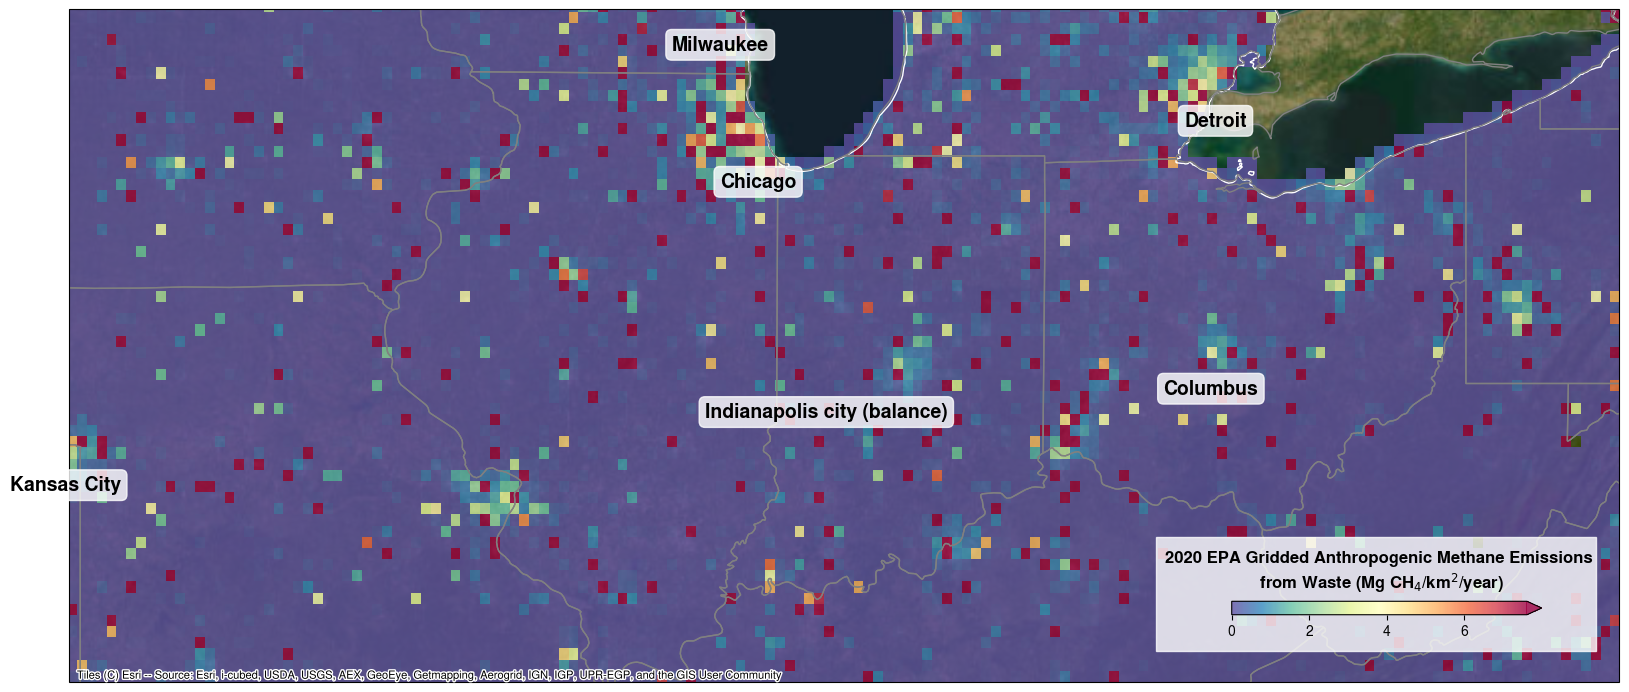

In [63]:
plt.close('all')
add_legend = True
add_shape = True
add_placenames = True

cbar_range = [0,np.nanmean(ds_sub.values)+1*np.nanstd(ds_sub.values)]

aoi_name='Midwest'
bounds = {'CONUS':[-135,23,-59,52],
        'Northeast':[-83.4,38.39,-66.5,48.36],
          'Eastern Seaboard':[-78.35,38.14,-72.52,41.64],
          'Midwest':[-94.73,37.05,-78.96,43.07]
        }

# colorbar formatting arguments
cbar_args = {'shrink':0.5,'orientation':'horizontal','aspect':12}

# font formatting
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Nimbus Sans','DejaVu Sans']

# Start generating a map
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(projection=ccrs.PlateCarree())
ax.set_ylim(bounds[aoi_name][1],bounds[aoi_name][3])
ax.set_xlim(bounds[aoi_name][0],bounds[aoi_name][2])
ax.add_feature(cf.STATES,linewidth=1,edgecolor='grey',zorder=2)

# Basemap
cx.add_basemap(ax,crs=ccrs.PlateCarree(),source=cx.providers.Esri.WorldImagery)#source=cx.providers.Esri.WorldTerrain)
# Data layer
pl = ds_sub.plot(ax=ax,cmap='Spectral_r',vmin=cbar_range[0],vmax=cbar_range[1],alpha=0.8,add_colorbar=False)
ax.set_title('')

# Add AOI outline if desired
if add_shape:
    try:
        shape.plot(ax=ax,facecolor='none',edgecolor='white',linewidth=1)
    except:
        print('No shape to add')
        
# Add legend
if add_legend:
    ax_ins = ax.inset_axes([0.75,0.1,0.2,0.02],transform=ax.transAxes)
    # Create a white rectangle larger than the colorbar
    pos = ax_ins.get_position()
    rect = patches.Rectangle((pos.x0-0.038, pos.y0-0.018), 
                pos.width+0.065, pos.height+0.05,
                edgecolor='white', 
                facecolor='white', transform=fig.transFigure,
                alpha=0.8,zorder=3)

    ax.add_patch(rect)
    cb = fig.colorbar(pl,cax=ax_ins,orientation="horizontal",
                    extend='max')
   
    cb.ax.xaxis.set_label_position('top')
    cb.set_label(f'{dt[0:4]} EPA Gridded Anthropogenic Methane Emissions\n from Waste (Mg CH$_4$/km$^2$/year)',
                 fontweight='bold',fontsize=12,labelpad=10
                )
    ax_ins.set_zorder(100)

# Add city names
if add_placenames:
    for idx, row in cities.iterrows():
        inlon = bounds[aoi_name][0]< row['INTPTLON'] < bounds[aoi_name][2]
        inlat = bounds[aoi_name][1] < row['INTPTLAT'] < bounds[aoi_name][3]
        if inlon and inlat:
            ax.annotate(row['NAME'],   # Replace with your column names
                xy=(row['INTPTLON'], row['INTPTLAT']),
                xytext=(25,-25), # Offset from the actual point location
                textcoords='offset points',
                ha='right', va='center',
                fontsize=14,
                fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='white', alpha=0.8),
                transform=ccrs.PlateCarree())

plt.show()

In [64]:
savename = f'EPA_Gridded_Methane_{var}_{dt[0:4]}_{aoi_name.replace(' ','_')}.png'
if add_legend:
    savename = savename.replace('.png','_legend.png')
if add_shape:
    savename = savename.replace('.png','_shape.png')
if add_placenames:
    savename = savename.replace('.png','_placenames.png')
fig.savefig(savename,dpi=300,bbox_inches='tight')
print(f'File saved as {savename}.')

File saved as EPA_Gridded_Methane_total-waste_2020_Midwest_legend_shape_placenames.png.


In [18]:
np.nanmean(ds_sub.values)

np.float64(417.10282832185646)

In [55]:
dt[0:4]

'2021'

In [19]:
np.nanstd(ds_sub.values)

np.float64(13967.268066609491)

In [2]:
import matplotlib.font_manager as fm
# Get all available fonts
fonts = [f.name for f in fm.fontManager.ttflist]
available_fonts = sorted(set(fonts))

# Print all fonts
for font in available_fonts:
    print(font)

C059
D050000L
DejaVu Sans
DejaVu Sans Display
DejaVu Sans Mono
DejaVu Serif
DejaVu Serif Display
Droid Sans Fallback
Inconsolata
Nimbus Mono PS
Nimbus Roman
Nimbus Sans
Nimbus Sans Narrow
Noto Mono
Noto Sans Mono
P052
STIXGeneral
STIXNonUnicode
STIXSizeFiveSym
STIXSizeFourSym
STIXSizeOneSym
STIXSizeThreeSym
STIXSizeTwoSym
Source Code Pro
Standard Symbols PS
URW Bookman
URW Gothic
Ubuntu
Ubuntu Condensed
Ubuntu Mono
Z003
cmb10
cmex10
cmmi10
cmr10
cmss10
cmsy10
cmtt10
